In [10]:
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# different layer
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, UpSampling2D, Concatenate)

In [2]:
img_size = 256
filter_list = [64, 128, 256, 512]

# initialization 
encoding_layers = [] # we want to get some encoded layers and concatenate to the decoding part
block_idx = 0 # just for naming each encoding layer (start form 0)

# UNet
ip = Input(shape=(img_size,img_size,1), name='Input')

x = ip # just copy input layer into x

for i, filters in enumerate(filter_list):
    # enumerate gives index(i) , and value (filter) pair
    # print(i,filters)
    
    # 1st Conv
    x = Conv2D(filters, (3,3), 
           padding='same', 
           activation=None,
           kernel_initializer='he_normal',
           name='E_Block%i_conv1'%block_idx)(x) # E_Block0_Conv1
    x = BatchNormalization(name='E_Block%i_BN1'%block_idx)(x) # E_Block0_BN1
    x = tf.nn.relu(x)
    x = Dropout(0.5, name='E_Block%i_Drop1'%block_idx)(x)
    
    # 2nd Conv
    x = Conv2D(filters, (3,3), 
           padding='same', 
           activation=None,
           kernel_initializer='he_normal',
           name='E_Block%i_conv2'%block_idx)(x) # E_Block0_Conv1
    x = BatchNormalization(name='E_Block%i_BN2'%block_idx)(x) # E_Block0_BN1
    x = tf.nn.relu(x)
    x = Dropout(0.5, name='E_Block%i_Drop2'%block_idx)(x)
    
    # save into empty list for copy and crop
    encoding_layers.append(x)
    
    # max pooling
    x = MaxPool2D(name='E_Block%i_MaxPool'%block_idx)(x)
    
    # increase the index of block_id
    block_idx += 1
    
# connecting path (3x3x1024)
x = Conv2D(filter_list[-1]*2, (3,3), padding='same', 
           activation=None, kernel_initializer='he_normal', 
           name='E_Block%i_Conv1'%block_idx)(x)
x = BatchNormalization(name='E_Block%i_BN1'%block_idx)(x)
x = tf.nn.relu(x)
x = Dropout(0.5, name='E_Block%i_Drop1'%block_idx)(x)


x = Conv2D(filter_list[-1]*2, (3,3), padding='same', 
           activation=None, 
           kernel_initializer='he_normal', 
           name='E_Block%i_conv2'%block_idx)(x)
x = BatchNormalization(name='E_Block%i_BN2'%block_idx)(x)
x = tf.nn.relu(x)
x = Dropout(0.5, name='E_Block%i_Drop2'%block_idx)(x)

# connecting path
encoding_layers.reverse()
filter_list.reverse()

# Decoding path
for i, filters in enumerate(filter_list):
    # upsampling
    x = UpSampling2D(size=(2,2), name='D_Block%i_UpSamp'%block_idx)(x)
    block_idx += 1
    
    # crop and copy (concatenate)
    x = Concatenate(name='D_Block%i_Con'%block_idx)([x,encoding_layers[i]])
    
    # conv1 (3x3)
    x = Conv2D(filters, (3,3), 
           padding='same', 
           activation=None,
           kernel_initializer='he_normal',
           name='D_Block%i_conv1'%block_idx)(x) # E_Block0_Conv1
    x = BatchNormalization(name='D_Block%i_BN1'%block_idx)(x) # E_Block0_BN1
    x = tf.nn.relu(x)
    x = Dropout(0.5, name='D_Block%i_Drop1'%block_idx)(x)
    
    # conv2 (3x3)
    x = Conv2D(filters, (3,3), 
           padding='same', 
           activation=None,
           kernel_initializer='he_normal',
           name='D_Block%i_conv2'%block_idx)(x) # E_Block0_Conv1
    x = BatchNormalization(name='D_Block%i_BN2'%block_idx)(x) # E_Block0_BN1
    x = tf.nn.relu(x)
    x = Dropout(0.5, name='D_Block%i_Drop2'%block_idx)(x)   
    
# final layer (1x1 conv)
op = Conv2D(kernel_size=(1,1), filters=1, activation='sigmoid', name='Output')(x) # 1=number of class (4 classes -> 4,softmax)

myUnet = Model(inputs=ip, outputs=op, name='UNet')
myUnet.summary()


Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
E_Block0_conv1 (Conv2D)         (None, 256, 256, 64) 640         Input[0][0]                      
__________________________________________________________________________________________________
E_Block0_BN1 (BatchNormalizatio (None, 256, 256, 64) 256         E_Block0_conv1[0][0]             
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 256, 256, 64) 0           E_Block0_BN1[0][0]               
_______________________________________________________________________________________________

### Prepare Data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2

batch_size = 8
seed = 0

train_img_dir = 'D:\\lung_ct-20220814T013554Z-001\\lung_ct\\train_images'
train_msk_dir = 'D:\\lung_ct-20220814T013554Z-001\\lung_ct\\train_masks'

test_img_dir = 'D:\\lung_ct-20220814T013554Z-001\\lung_ct\\test_images'
test_msk_dir = 'D:\\lung_ct-20220814T013554Z-001\\lung_ct\\test_masks'

# 4 image data generator
# train (images/masks)
imgDataGenTrain = ImageDataGenerator( rescale=1/255,
                                      data_format = "channels_last",
                                      rotation_range = 180,
                                      width_shift_range = 0.15,
                                      height_shift_range = 0.15,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      fill_mode = 'constant',
                                      cval = 0.0,
                                      horizontal_flip = True,
                                      vertical_flip = True)
 
maskDataGenTrain = ImageDataGenerator(rescale=1/1,
                                      data_format = "channels_last",
                                      rotation_range = 180,
                                      width_shift_range = 0.15,
                                      height_shift_range = 0.15,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      fill_mode = 'constant',
                                      cval = 0.0,
                                      horizontal_flip = True,
                                      vertical_flip = True)

# test (images/masks)
imgDataGenTest = ImageDataGenerator(rescale=1/255)
maskDataGenTest = ImageDataGenerator(rescale=1/1)

# flow the images into 4 image data generators
trainImgGenerator = imgDataGenTrain.flow_from_directory(train_img_dir,
                                                   target_size=(img_size,img_size),
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   color_mode='grayscale',
                                                   class_mode=None,
                                                   seed=seed)
 
trainMskGenerator = maskDataGenTrain.flow_from_directory(train_msk_dir,
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    color_mode='grayscale',
                                                    class_mode=None,
                                                    seed=seed)

testImgGenerator = imgDataGenTest.flow_from_directory( test_img_dir,
                                                   target_size=(img_size,img_size),
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   color_mode='grayscale',
                                                   class_mode=None,
                                                   seed=seed)
 
testMskGenerator = maskDataGenTest.flow_from_directory( test_msk_dir,
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    color_mode='grayscale',
                                                    class_mode=None,
                                                    seed=seed)

# Zip together image (x) and mask (y) data generators 
trainGenerator = zip(trainImgGenerator, trainMskGenerator)
testGenerator = zip(testImgGenerator, testMskGenerator)

Found 3282 images belonging to 1 classes.
Found 3282 images belonging to 1 classes.
Found 1990 images belonging to 1 classes.
Found 1990 images belonging to 1 classes.


### Checking the shapes of the input data

In [4]:
# Check data
train_images = trainImgGenerator.__getitem__(0)
train_masks = trainMskGenerator.__getitem__(0)

test_images = testImgGenerator.__getitem__(0)
test_masks = testMskGenerator.__getitem__(0)

print(train_images.shape)
print(train_masks.shape)

(8, 256, 256, 1)
(8, 256, 256, 1)


In [5]:
# Write a function for plotting contours on images
def draw_contours(x, y_true, y_pred=None, pred=False):
  image = cv2.merge([x, x, x])
  image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
  contours = cv2.findContours(y_true.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  image = cv2.drawContours(image, contours, -1, [0,255,0], 1)
  if pred:
    contours = cv2.findContours(y_pred.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    image = cv2.drawContours(image, contours, -1, [255,0,0], 1)
  return image

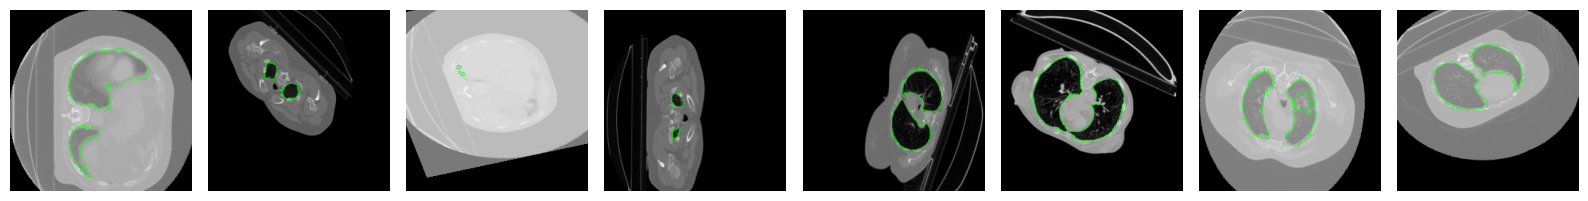

In [6]:
# Display some of the traning images with contours
plt.figure(figsize=(16,8))
for i in range(8):
  plt.subplot(4,8,i+1)
  cont_image = draw_contours(train_images[i,:,:,0], train_masks[i,:,:,0])
  plt.imshow(cont_image)
  plt.axis('off')
plt.tight_layout()
plt.show()

### Compilation

In [7]:
# Dice coefficient metric and loss functions
# smooth to avoid division by zero when both y_pred and y_true do not contain any foreground pixels

def dice(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice(y_true, y_pred)

In [8]:
myUnet.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice])

### Train the Model

In [12]:
# Train model
# Early stopping callback
early_stop = EarlyStopping(monitor='val_dice', min_delta=0, patience=10,
                           verbose=0, mode='max', baseline=None, 
                           restore_best_weights=True)
epochs = 10
 
history = myUnet.fit(trainGenerator,
                    epochs = epochs,
                    steps_per_epoch = (3282//32),
                    validation_data = testGenerator,
                    validation_steps = (1990//32),
                    verbose = 1,
                    callbacks = [early_stop])

Epoch 1/10
  5/102 [>.............................] - ETA: 1:11:02 - loss: -0.0936 - accuracy: 0.5554 - dice: 1.0936

KeyboardInterrupt: 